In [56]:
# TASK 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
df1 = pd.read_csv('./DATA/network_analysis_data1.csv')
df2 = pd.read_csv('./DATA/network_analysis_data2.csv')
df3 = pd.read_csv('./DATA/network_analysis_data3.csv')
df4 = pd.read_csv('./DATA/network_analysis_data4.csv')
df5 = pd.read_csv('./DATA/network_analysis_data5.csv')
df6 = pd.read_csv('./DATA/network_analysis_data6.csv')

df = pd.concat([df1,df2,df3,df4,df5,df6])

# Total number of flows
total_flows = len(df)
print(f"Total number of network flows recorded: {total_flows}")

# Top 5 most used protocols
top_protocols = df['protocolName'].value_counts().head(5)
print("\nTop 5 most used protocols:")
print(top_protocols)

# Top 10 most active source IPs
top_source_ips = df['source'].value_counts().head(10)
print("\nTop 10 most active source IPs:")
print(top_source_ips)

# Top 10 most active destination IPs
top_dest_ips = df['destination'].value_counts().head(10)
print("\nTop 10 most active destination IPs:")
print(top_dest_ips)

# Average packet size
Avg_packet_size = df['totalSourceBytes'].mean() / df['totalSourcePackets'].mean()
print(f"\nAverage packet size: {Avg_packet_size:.2f} bytes")

# Most common source-destination pair
df['src_dst_pair'] = df['source'] + ' -> ' + df['destination']
most_common_pair = df['src_dst_pair'].value_counts().idxmax()
pair_count = df['src_dst_pair'].value_counts().max()
print(f"\nMost common source-destination pair: {most_common_pair} (Count: {pair_count})")



Total number of network flows recorded: 2071657

Top 5 most used protocols:
protocolName
tcp_ip     1644056
udp_ip      419246
icmp_ip       8211
igmp            77
ip              66
Name: count, dtype: int64

Top 10 most active source IPs:
source
192.168.5.122    268267
192.168.2.107    208379
192.168.4.118    135374
192.168.1.101    116292
192.168.4.121    105454
192.168.1.105    101359
192.168.2.109     99183
192.168.3.116     97241
192.168.2.110     90658
192.168.3.115     88915
Name: count, dtype: int64

Top 10 most active destination IPs:
destination
198.164.30.2       232409
192.168.5.122      199437
203.73.24.75       193200
125.6.164.51       106826
67.220.214.50       49298
202.210.143.140     36189
82.98.86.183        25214
95.211.98.12        25095
209.112.44.10       21824
62.140.213.243      20509
Name: count, dtype: int64

Average packet size: 124.04 bytes

Most common source-destination pair: 192.168.5.122 -> 198.164.30.2 (Count: 232409)


In [57]:
# Convert startDateTime to datetime
df['startDateTime'] = pd.to_datetime(df['startDateTime'])

# Extract hour as time window
df['time_window'] = df['startDateTime'].dt.floor('H')

# Group by source IP and count unique time windows
source_window_counts = df.groupby('source')['time_window'].nunique()
consistent_sources = source_window_counts[source_window_counts > 1]
consistent_sources.sort_values(ascending=False, inplace=True)
print("\nSource IPs communicating over multiple time windows:")
print(consistent_sources)

# Repeat for destination IPs
dest_window_counts = df.groupby('destination')['time_window'].nunique()
consistent_dests = dest_window_counts[dest_window_counts > 1]
consistent_dests.sort_values(ascending=False, inplace=True)
print("\nDestination IPs communicating over multiple time windows:")
print(consistent_dests)

/tmp/ipykernel_45134/3042546823.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['time_window'] = df['startDateTime'].dt.floor('H')



Source IPs communicating over multiple time windows:
source
192.168.2.112    145
192.168.4.120    145
192.168.4.119    145
192.168.1.101    145
192.168.2.107    145
                ... 
137.132.250.7      2
91.78.224.165      2
92.113.214.61      2
92.129.5.134       2
92.17.244.213      2
Name: time_window, Length: 735, dtype: int64

Destination IPs communicating over multiple time windows:
destination
198.164.30.2       145
192.168.2.111      145
192.168.5.122      145
192.168.4.255      145
192.168.2.255      145
                  ... 
72.13.32.84          2
72.129.114.166       2
72.12.123.215        2
200.120.185.178      2
72.144.160.165       2
Name: time_window, Length: 12290, dtype: int64


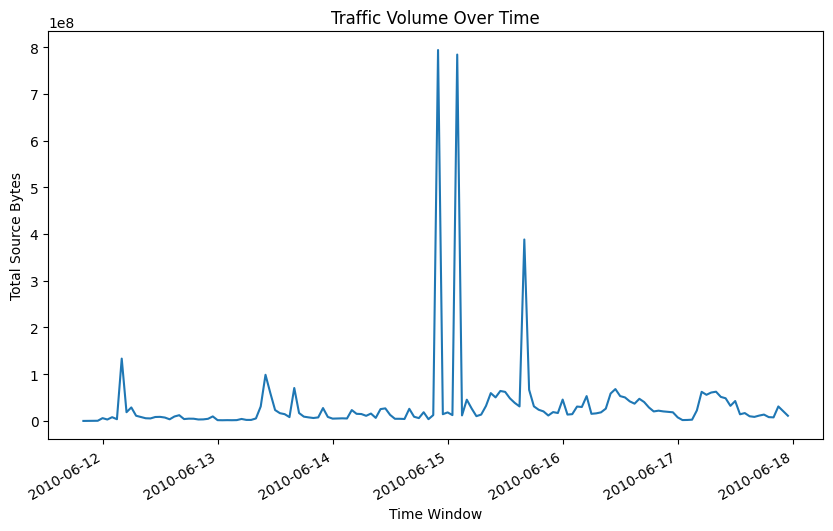


Time windows with irregular traffic spikes:
time_window
2010-06-14 22:00:00    793893427
2010-06-15 02:00:00    784152020
2010-06-15 16:00:00    388361383
Name: totalSourceBytes, dtype: int64


In [58]:
# traffic volume by time window
traffic_by_time = df.groupby('time_window')['totalSourceBytes'].sum()

# Plot traffic volume
plt.figure(figsize=(10, 6))
traffic_by_time.plot()
plt.title('Traffic Volume Over Time')
plt.xlabel('Time Window')
plt.ylabel('Total Source Bytes')
plt.show()


mean_traffic = traffic_by_time.mean()
std_traffic = traffic_by_time.std()
spikes = traffic_by_time[traffic_by_time > mean_traffic + 2 * std_traffic]
print("\nTime windows with irregular traffic spikes:")
print(spikes)

In [59]:
# Variance of packet sizes
df['avg_source_packet_size'] = df['totalSourceBytes'] / df['totalSourcePackets']
packet_size_variance = df['avg_source_packet_size'].var()
print(f"\nVariance of packet sizes: {packet_size_variance:.2f}")



Variance of packet sizes: 1172.25


In [60]:
#TASK 2
#Part a: counting unique IPs
# Estimate the number of unique IPs using HyperLogLog
from datasketch import HyperLogLog
import hashlib

# Combine source and destination IPs into a single set for unique IPs
all_ips = pd.concat([df['source'], df['destination']]).unique()
exact_unique_ips = len(all_ips)
print(f"Exact number of unique IPs : {exact_unique_ips}")

# Initialize HyperLogLog with 16-bit registers
hll = HyperLogLog(p=16)

def hash_ip(ip):
    return hashlib.sha1(ip.encode('utf-8')).digest()

for ip in pd.concat([df['source'], df['destination']]):
    hll.update(hash_ip(ip))

hll_estimate = int(hll.count())
print(f"Estimated number of unique IPs (using HLL): {hll_estimate}")

# Calculate error percentage
error = abs(exact_unique_ips - hll_estimate) / exact_unique_ips * 100
print(f"Error rate: {error:.2f}%")

# Check if error is within 10%
if error <= 10:
    print("Error is within the acceptable limit of 10%.")
else:
    print("Error exceeds 10%. Consider increasing HLL precision (p).")

Exact number of unique IPs : 34801
Estimated number of unique IPs (using HLL): 34817
Error rate: 0.05%
Error is within the acceptable limit of 10%.


In [61]:
import time
import sys

# Measure computation time for HLL
start_time = time.time()
hll = HyperLogLog(p=12)
for ip in pd.concat([df['source'], df['destination']]):
    hll.update(hash_ip(ip))
hll_time = time.time() - start_time
print(f"HLL computation time: {hll_time:.4f} seconds")

# Measure computation time for exact method
start_time = time.time()
exact_unique_ips = len(pd.concat([df['source'], df['destination']]).unique())
exact_time = time.time() - start_time
print(f"Exact method computation time: {exact_time:.4f} seconds")

# Approximate memory usage
hll_memory = sys.getsizeof(hll) 

exact_memory = sys.getsizeof(all_ips) + sum(sys.getsizeof(ip) for ip in all_ips)
print(f"HLL memory usage: ~{hll_memory} bytes")
print(f"Exact method memory usage: ~{exact_memory} bytes")

HLL computation time: 17.5351 seconds
Exact method computation time: 0.4915 seconds
HLL memory usage: ~80 bytes
Exact method memory usage: ~2158365 bytes


In [62]:
# Implementing Count-Min Sketch
import random

class CountMinSketch:
    def __init__(self, width, depth):
        self.width = width
        self.depth = depth
        self.table = [[0] * width for _ in range(depth)]
        self.hash_functions = [self._hash_function(random.randint(0,10000)) for _ in range(depth)]

    def _hash_function(self, seed):
        def hash_func(x):
            x=str(x)+str(seed)
            return (hash(x)) % self.width
        return hash_func

    def add(self, item):
        for i in range(self.depth):
            index = self.hash_functions[i](item)
            self.table[i][index] += 1

    def query(self, item):
        min_estimate = float('inf')
        for i in range(self.depth):
            index = self.hash_functions[i](item)
            min_estimate = min(min_estimate, self.table[i][index])
        return min_estimate

In [72]:
# Part b: Identifying frequently contacted destination IPs
# We will use the CMS(Count-Min Sketch) algorithm to identify frequently contacted destination IPs

# Exact counts
time_start = time.time()
exact_counts = df['destination'].value_counts().to_dict()
top_exact = sorted(exact_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 exact heavy hitters:")
for ip, count in top_exact:
    print(f"{ip}: {count}")
exact_time= time.time()-time_start
# CMS estimation
time_start = time.time()
cms = CountMinSketch(depth=5, width=1000)
def hash_ip(ip):
    return hashlib.sha1(ip.encode('utf-8')).digest()
for ip in df['destination']:
    cms.add(hash_ip(ip))
unique_dests = df['destination'].unique()
cms_counts = {ip: cms.query(hash_ip(ip)) for ip in unique_dests}
top_cms = sorted(cms_counts.items(), key=lambda x: x[1], reverse=True)[:10]
time_end = time.time()
cms_time = time_end - time_start
print("\nTop 10 CMS heavy hitters:")
for ip, count in top_cms:
    print(f"{ip}: {count}")

# Comparison
print("\nComparison (Exact vs CMS):")
for ip, exact_count in top_exact[:10]:
    cms_count = cms.query(hash_ip(ip))
    error = abs(exact_count - cms_count) / exact_count * 100
    print(f"IP: {ip}, Exact: {exact_count}, CMS: {cms_count}, Error: {error:.2f}%")
errors = [abs(exact_counts[ip] - cms_counts[ip]) / exact_counts[ip] * 100 
          for ip, _ in top_exact if ip in exact_counts]
avg_error = sum(errors) / len(errors)
print(f"Average error: {avg_error:.2f}%")
print("Error within 10%:" if avg_error <= 10 else "Error exceeds 10%:", avg_error <= 10)
cms_memory = sys.getsizeof(cms) + sys.getsizeof(cms.table) + cms.depth*cms.width*sys.getsizeof(cms.table[0][0])

exact_memory = sys.getsizeof(exact_counts) + sum(sys.getsizeof(k) + sys.getsizeof(v) 
                                                 for k, v in exact_counts.items())
print(f"\nCMS time: {cms_time:.4f}s, Memory: ~{cms_memory} bytes")
print(f"Exact time: {exact_time:.4f}s, Memory: ~{exact_memory} bytes")


Top 10 exact heavy hitters:
198.164.30.2: 232409
192.168.5.122: 199437
203.73.24.75: 193200
125.6.164.51: 106826
67.220.214.50: 49298
202.210.143.140: 36189
82.98.86.183: 25214
95.211.98.12: 25095
209.112.44.10: 21824
62.140.213.243: 20509

Top 10 CMS heavy hitters:
198.164.30.2: 232788
192.168.5.122: 199648
203.73.24.75: 193302
125.6.164.51: 107527
67.220.214.50: 49355
202.210.143.140: 36353
82.98.86.183: 25362
95.211.98.12: 25219
209.112.44.10: 22041
62.140.213.243: 20842

Comparison (Exact vs CMS):
IP: 198.164.30.2, Exact: 232409, CMS: 232788, Error: 0.16%
IP: 192.168.5.122, Exact: 199437, CMS: 199648, Error: 0.11%
IP: 203.73.24.75, Exact: 193200, CMS: 193302, Error: 0.05%
IP: 125.6.164.51, Exact: 106826, CMS: 107527, Error: 0.66%
IP: 67.220.214.50, Exact: 49298, CMS: 49355, Error: 0.12%
IP: 202.210.143.140, Exact: 36189, CMS: 36353, Error: 0.45%
IP: 82.98.86.183, Exact: 25214, CMS: 25362, Error: 0.59%
IP: 95.211.98.12, Exact: 25095, CMS: 25219, Error: 0.49%
IP: 209.112.44.10, Exac

In [64]:
# Implementation of the Bloom Filter
class BloomFilter:
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = [0] * size
        

    def _hash(self, item, seed):
        item = str(item)+str(seed)
        return (hash(item)) % self.size

    def add(self, item):
        for i in range(self.hash_count):
            index = self._hash(item,i)
            self.bit_array[index] = 1

    def check(self, item):
        seed = random.randint(0,10000)
        for i in range(self.hash_count):
            index = self._hash(item,i)
            if self.bit_array[index] == 0:
                return False
        return True

In [75]:
#Part c: Efficient Membership Testing for Blocklists 
# Using Bloom Filter

# We can use each IP as a test IP first then later we add it.
IPs = pd.concat([df['source'], df['destination']])
exact_set=set()
bf = BloomFilter(size=250000, hash_count=5)
error=0
total=0
fake_IPs = pd.Series(np.random.choice(IPs, size=10000, replace=False))
fake_IPs = set(fake_IPs)

for IP in IPs:
    if(IP in fake_IPs):
        continue
    exact_set.add(IP)
    bf.add(IP)

for IP in fake_IPs:
    total+=1
    if bf.check(IP):
        error+=1
print(f"Total Bits set:{sum(bf.bit_array)}")
print("Total errors:", error)
print("Total IPs checked:", total)
print("Size of the Bloom filter:", len(bf.bit_array), "bits")
print("Size of the exact set:", len(exact_set), "IPs")

print(f"\nObserved false positive rate: {error/total:.2%} (based on {len(fake_IPs)} IPs)")



Total Bits set:122513
Total errors: 30
Total IPs checked: 1212
Size of the Bloom filter: 250000 bits
Size of the exact set: 33589 IPs

Observed false positive rate: 2.48% (based on 1212 IPs)



Packet Size Stats:
Mean: 85.06 bytes
Std Dev: 34.24 bytes

Packet Size Anomaly Detection Threshold: 247.00 bytes
Packet Size Anomalies (sample):
               source    destination  avg_packet_size
22      192.168.2.113  192.168.2.255            251.5
128     192.168.4.119  192.168.4.255            251.5
607     192.168.5.123  192.168.5.255            259.0
957     192.168.1.103  192.168.1.255            251.5
1146    192.168.3.114  192.168.3.255            256.0
...               ...            ...              ...
519784  192.168.4.119  192.168.4.255            256.0
520133  192.168.2.110   82.98.86.172            258.6
520453  192.168.5.123  192.168.5.255            253.0
521072  192.168.1.103  192.168.1.255            256.0
521442  192.168.3.114  192.168.3.255            256.0

[6512 rows x 3 columns]


/home/arthur/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


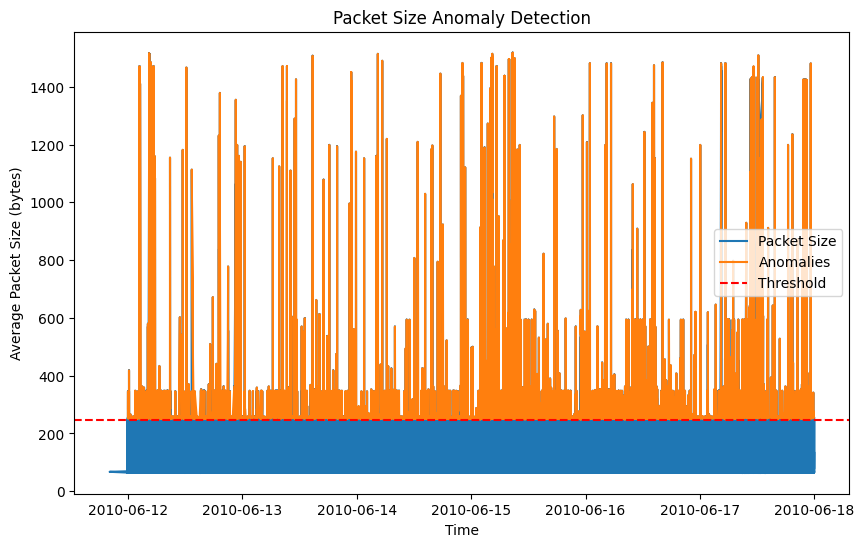

In [66]:
#TASK 3

# Devloping the data for Packet Size Anomaly Detection

# Convert timestamps
df['startDateTime'] = pd.to_datetime(df['startDateTime'])
df['stopDateTime'] = pd.to_datetime(df['stopDateTime'])

# Add derived columns
df['avg_packet_size'] = df['totalSourceBytes'] / df['totalSourcePackets'].replace(0, np.nan)  #Replaced division by zero with NaN
df['hour'] = df['startDateTime'].dt.floor('h')   #Hour time window
df['day'] = df['startDateTime'].dt.floor('D')    #Day time window

# Packet size stats
# We are more into the sudden spikes of packet size so prefer to use 99th percentile based static threshold

packet_mean = df['avg_packet_size'].mean()
packet_std = df['avg_packet_size'].std()
# packet_upper = packet_mean + 2 * packet_std #Higher Threshold
# packet_lower = packet_mean - 2 * packet_std #Lower Threshold

packet_threshold=np.percentile(df['avg_packet_size'].dropna(), 99)

print(f"\nPacket Size Stats:")
print(f"Mean: {packet_mean:.2f} bytes")
print(f"Std Dev: {packet_std:.2f} bytes")
# print(f"Upper Threshold: {packet_upper:.2f} bytes")
# print(f"Lower Threshold: {packet_lower:.2f} bytes")

print(f"\nPacket Size Anomaly Detection Threshold: {packet_threshold:.2f} bytes")

packet_anomalies = df[(df['avg_packet_size'] > packet_threshold)]
# packet_anomalies = df[(df['avg_packet_size'] > packet_upper)]

print("Packet Size Anomalies (sample):")
print(packet_anomalies[['source', 'destination', 'avg_packet_size']])

# Plotting packet sizes
plt.figure(figsize=(10, 6))
plt.plot(df['startDateTime'], df['avg_packet_size'], label='Packet Size')
plt.plot(packet_anomalies['startDateTime'], packet_anomalies['avg_packet_size'], label='Anomalies')
plt.axhline(packet_threshold, color='red', linestyle='--', label='Threshold')
plt.title('Packet Size Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Average Packet Size (bytes)')
plt.legend()
plt.show()


Flow Count Stats (per hour):
Mean: 34919444.25 flows
Std Dev: 96589857.57 flows
Threshold: 131509301.81 flows
Hourly Flow Count Anomalies:
hour
2010-06-12 04:00:00    133409213
2010-06-14 22:00:00    793893427
2010-06-15 02:00:00    784152020
2010-06-15 16:00:00    388361383
Name: totalSourceBytes, dtype: int64


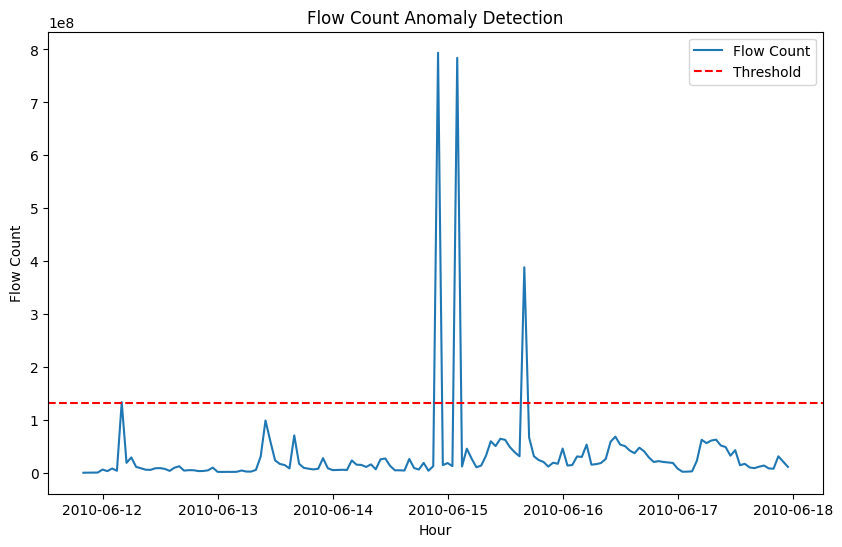

In [67]:
# Developing the data for Flow Duration Anomaly Detection

# Flow counts per hour
hourly_flows = df.groupby('hour')['totalSourceBytes'].sum()
flow_mean = hourly_flows.mean()
flow_std = hourly_flows.std()
flow_threshold = flow_mean + flow_std

print(f"\nFlow Count Stats (per hour):")
print(f"Mean: {flow_mean:.2f} flows")
print(f"Std Dev: {flow_std:.2f} flows")
print(f"Threshold: {flow_threshold:.2f} flows")

flow_anomalies = hourly_flows[hourly_flows > flow_threshold]
print("Hourly Flow Count Anomalies:")
print(flow_anomalies)

# Plotting flow counts
plt.figure(figsize=(10, 6))
plt.plot(hourly_flows.index, hourly_flows.values, label='Flow Count')
plt.axhline(flow_threshold, color='red', linestyle='--', label='Threshold')
plt.title('Flow Count Anomaly Detection')
plt.xlabel('Hour')
plt.ylabel('Flow Count')
plt.legend()
plt.show()


Protocol Distribution Stats:
Mean: 849706476.67 flows
Std Dev: 2005153490.22 flows
Threshold: 852136539.67 flows
Protocol Anomalies:
protocolName
tcp_ip    4940765626
Name: totalSourceBytes, dtype: int64


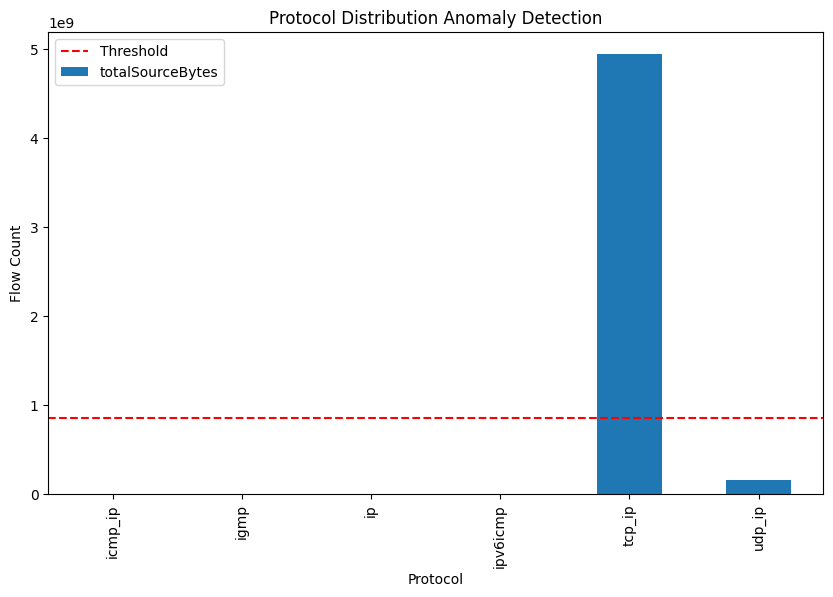

In [68]:
# Protocol counts
protocol_counts = df.groupby('protocolName')['totalSourceBytes'].sum()
protocol_mean = protocol_counts.mean()
protocol_std = protocol_counts.std()

# I am using MAD statical threshold: mean+2*MAD 
def calculate_mad(data):
    median = np.median(data)
    deviations = np.abs(data - median)
    mad = np.median(deviations)
    return median, mad

meadian,mad = calculate_mad(protocol_counts)
protocol_threshold=protocol_mean+2*mad


# We couldn't use the std deviation because data is very skewed


print(f"\nProtocol Distribution Stats:")
print(f"Mean: {protocol_mean:.2f} flows")
print(f"Std Dev: {protocol_std:.2f} flows")
print(f"Threshold: {protocol_threshold:.2f} flows")

protocol_anomalies = protocol_counts[protocol_counts > protocol_threshold]
print("Protocol Anomalies:")
print(protocol_anomalies)

# Plotting protocol distribution
plt.figure(figsize=(10, 6))
protocol_counts.plot(kind='bar')
plt.axhline(protocol_threshold, color='red', linestyle='--', label='Threshold')
plt.title('Protocol Distribution Anomaly Detection')
plt.xlabel('Protocol')
plt.ylabel('Flow Count')
plt.legend()
plt.show()


Hourly Traffic Stats:
Mean: 34919444.25 bytes
Std Dev: 96589857.57 bytes
Threshold: 54595016.25 bytes
Hourly Anomalies:
hour
2010-06-12 04:00:00    133409213
2010-06-13 10:00:00     98785428
2010-06-13 11:00:00     59908262
2010-06-13 16:00:00     70526404
2010-06-14 22:00:00    793893427
2010-06-15 02:00:00    784152020
2010-06-15 09:00:00     59505194
2010-06-15 11:00:00     64140373
2010-06-15 12:00:00     62168326
2010-06-15 16:00:00    388361383
2010-06-15 17:00:00     66710648
2010-06-16 10:00:00     58598601
2010-06-16 11:00:00     68189788
2010-06-17 05:00:00     62260634
2010-06-17 06:00:00     55966976
2010-06-17 07:00:00     60818183
2010-06-17 08:00:00     62556332
Name: totalSourceBytes, dtype: int64

Daily Traffic Stats:
Mean: 728319837.14 bytes
Std Dev: 614803490.61 bytes
Threshold: 1309308721.14 bytes
Daily Anomalies:
day
2010-06-15    1887100602
Name: totalSourceBytes, dtype: int64


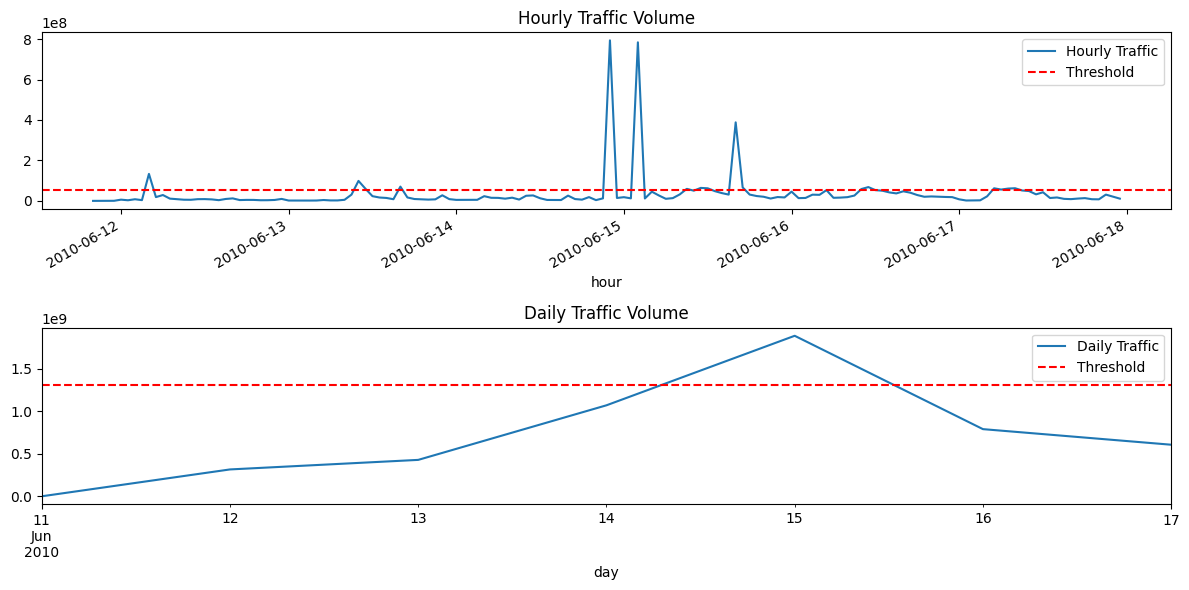

In [69]:
# Hourly traffic volume
hourly_traffic = df.groupby('hour')['totalSourceBytes'].sum()

hourly_mean = hourly_traffic.mean()
hourly_std = hourly_traffic.std()
# hourly_threshold = hourly_mean + 2 * hourly_std
# use MAD
median, mad = calculate_mad(hourly_traffic)
hourly_threshold = hourly_mean + 2 * mad

# Daily traffic volume
daily_traffic = df.groupby('day')['totalSourceBytes'].sum()


daily_mean = daily_traffic.mean()
daily_std = daily_traffic.std()
# daily_threshold = daily_mean + 2 * daily_std
# use MAD 
median, mad = calculate_mad(daily_traffic)
daily_threshold = daily_mean + 2 * mad


print(f"\nHourly Traffic Stats:")
print(f"Mean: {hourly_mean:.2f} bytes")
print(f"Std Dev: {hourly_std:.2f} bytes")
print(f"Threshold: {hourly_threshold:.2f} bytes")
print("Hourly Anomalies:")
print(hourly_traffic[hourly_traffic > hourly_threshold])

print(f"\nDaily Traffic Stats:")
print(f"Mean: {daily_mean:.2f} bytes")
print(f"Std Dev: {daily_std:.2f} bytes")
print(f"Threshold: {daily_threshold:.2f} bytes")
print("Daily Anomalies:")
print(daily_traffic[daily_traffic > daily_threshold])

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
hourly_traffic.plot(label='Hourly Traffic')
plt.axhline(hourly_threshold, color='r', linestyle='--', label='Threshold')
plt.title('Hourly Traffic Volume')
plt.legend()

plt.subplot(2, 1, 2)
daily_traffic.plot(label='Daily Traffic')
plt.axhline(daily_threshold, color='r', linestyle='--', label='Threshold')
plt.title('Daily Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Will see this one

# Traffic volume per source IP
source_traffic = df.groupby('source')['totalSourceBytes'].sum()
source_mean = source_traffic.mean()
source_std = source_traffic.std()
source_lower = source_mean-2*source_std
source_upper = source_mean+2*source_std

print(f"\nSource Traffic Stats:")
print(f"Mean: {source_mean:.2f} bytes")
print(f"Std Dev: {source_std:.2f} bytes")
print(f"Upper Threshold: {source_upper:.2f} bytes")
print(f"Lower Threshold: {source_lower:.2f} bytes")

outlier_ips_high = source_traffic[source_traffic > source_upper]
outlier_ips_low = source_traffic[source_traffic < source_lower]
print("High Traffic Outlier IPs:")
print(outlier_ips_high)
print("Low Traffic Outlier IPs (if positive):")
print(outlier_ips_low[outlier_ips_low > 0])

0

Source Traffic Stats:
Mean: 2057400.67 bytes
Std Dev: 38925249.02 bytes
Upper Threshold: 79907898.71 bytes
Lower Threshold: -75793097.37 bytes
High Traffic Outlier IPs:
source
192.168.1.101     229244162
192.168.1.102     130811393
192.168.1.103     190875178
192.168.1.104      82962706
192.168.1.105     233991932
192.168.2.106      96860665
192.168.2.107    1766723841
192.168.2.109     279555269
192.168.2.110     176514136
192.168.2.111      86681550
192.168.2.112     219642794
192.168.2.113     219011411
192.168.3.114     101839027
192.168.3.115     133416562
192.168.3.116     130994152
192.168.3.117      82619605
192.168.4.118     201191844
192.168.4.119      90075472
192.168.4.120     149211253
192.168.4.121     348236805
Name: totalSourceBytes, dtype: int64
Low Traffic Outlier IPs (if positive):
Series([], Name: totalSourceBytes, dtype: int64)


839735.366334098
IPs with Sudden Behavior Changes:
IP: 131.202.243.90, Hour: 2010-06-17 15:00:00, Spike: 216003.00
IP: 142.167.88.44, Hour: 2010-06-13 23:00:00, Spike: 0.00
IP: 187.60.74.67, Hour: 2010-06-15 01:00:00, Spike: 0.00
IP: 192.168.1.101, Hour: 2010-06-17 23:00:00, Spike: 667923.00
IP: 192.168.1.102, Hour: 2010-06-17 19:00:00, Spike: 223136.00
IP: 192.168.1.103, Hour: 2010-06-17 19:00:00, Spike: 225418.00
IP: 192.168.1.104, Hour: 2010-06-17 19:00:00, Spike: 172529.00
IP: 192.168.1.105, Hour: 2010-06-17 22:00:00, Spike: 90848.00
IP: 192.168.2.106, Hour: 2010-06-17 06:00:00, Spike: 1557952.00
IP: 192.168.2.107, Hour: 2010-06-17 13:00:00, Spike: 84603.00
IP: 192.168.2.108, Hour: 2010-06-17 11:00:00, Spike: 2320984.00
IP: 192.168.2.109, Hour: 2010-06-17 22:00:00, Spike: 1065639.00
IP: 192.168.2.110, Hour: 2010-06-17 10:00:00, Spike: 425914.00
IP: 192.168.2.111, Hour: 2010-06-17 11:00:00, Spike: 2271046.00
IP: 192.168.2.112, Hour: 2010-06-17 14:00:00, Spike: 444877.00
IP: 192.168.

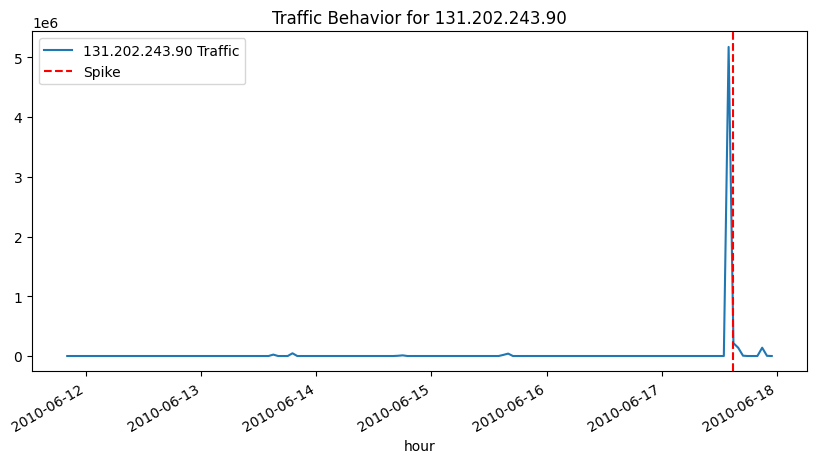


Dest Source Stats: Mean: 1.74, Threshold: 27.53
Correlated Destinations: destination
192.168.2.107    2345
192.168.5.122     104
Name: source, dtype: int64


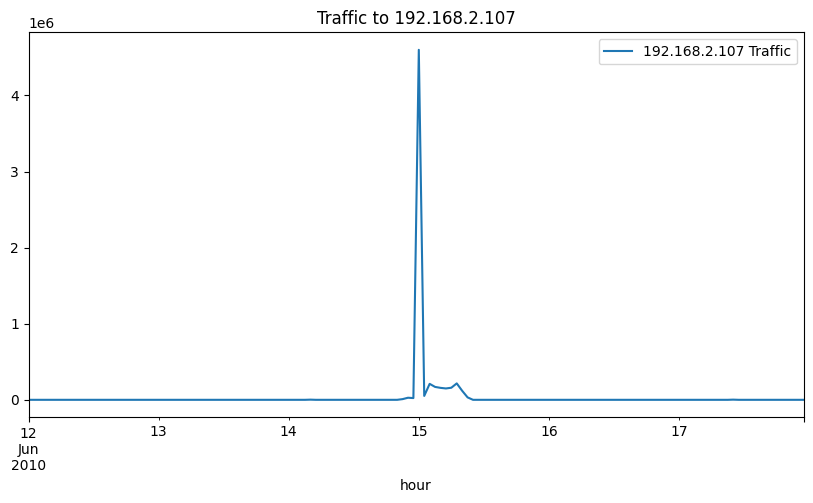

The IP with maximum sources: 192.168.5.122


In [ ]:
# part b : Behavioral Analysis
from datetime import timedelta

source_hourly = df.groupby(['source', 'hour'])['totalSourceBytes'].sum().unstack(fill_value=0)
source_changes = source_hourly.diff(axis=1).abs()
traffic_mean = source_hourly.mean().mean()
traffic_std = source_hourly.std().mean()
inactivity_threshold = traffic_mean * 0.4
spike_threshold = traffic_mean +  2*traffic_std

behavior_changes = {}
for ip in source_hourly.index:
    traffic = source_hourly.loc[ip]
    changes = source_changes.loc[ip]
    for hour in traffic.index[1:]:
        curr_traffic = traffic[hour]
        curr_change = changes[hour]
        if  curr_change > spike_threshold:
            behavior_changes[ip] = (hour ,curr_traffic)

print("IPs with Sudden Behavior Changes:")
for ip, (hour, curr) in behavior_changes.items():
    print(f"IP: {ip}, Hour: {hour}, Spike: {curr:.2f}")

if behavior_changes:
    example_ip = list(behavior_changes.keys())[0]
    example_traffic = source_hourly.loc[example_ip]
    print(example_traffic)
    plt.figure(figsize=(10, 5))
    source_hourly.loc[example_ip].plot(label=f"{ example_ip} Traffic")
    plt.axvline(behavior_changes[example_ip][0], color='r', linestyle='--', label='Spike')
    plt.title(f"Traffic Behavior for {example_ip}")
    plt.legend()
    plt.show()

# 3.2.2 Correlation Patterns
dest_sources = df.groupby('destination')['source'].nunique()
sources_mean = dest_sources.mean()
sources_std = dest_sources.std()
sources_threshold = sources_mean + 2 * sources_std
print(f"\nDest Source Stats: Mean: {sources_mean:.2f}, Threshold: {sources_threshold:.2f}")
correlated_dests = dest_sources[dest_sources > sources_threshold]
print("Correlated Destinations:", correlated_dests)

if not correlated_dests.empty:
    top_dest = correlated_dests.idxmax()
    top_dest_traffic = df[df['destination'] == top_dest].groupby('hour')['totalSourceBytes'].sum()
    plt.figure(figsize=(10, 5))
    top_dest_traffic.plot(label=f"{top_dest} Traffic")
    plt.title(f"Traffic to {top_dest}")
    plt.legend()
    plt.show()

# 3.2.3 Source Bursts
last_hour = df['startDateTime'].max()
# Top destination IP in each window of 15 mins.
top_destinations=[]
while (True):
    lower_limit = last_hour-timedelta(hours=0.25)

    recent_df = df[(df['startDateTime'] >= lower_limit) & (df['startDateTime'] < last_hour)]
  
    recent_dests = recent_df.groupby('destination')['source'].nunique()
    #append maximum of each window.
    if not recent_dests.empty:
        top_dest = recent_dests.idxmax()
        top_destinations.append(top_dest)
    last_hour = lower_limit
    if last_hour < df['startDateTime'].min():
        break


# Find maximum times a destination IP topped
destination_counts={}
max_count=0
for IP in top_destinations:
    if IP in destination_counts:
        destination_counts[IP]+=1
    else:
        destination_counts[IP]=1
    if destination_counts[IP]>max_count:
        max_IP=IP
        max_count=destination_counts[IP]

print("The IP with maximum sources:",max_IP)


Duration Stats: Mean: 48.99, Std: 619.77, Threshold: 1288.53
Long-Duration Connections: 8093
               source      destination  duration protocolName  \
138192  192.168.2.112   131.202.243.84    5220.0       tcp_ip   
149543  192.168.1.103    69.84.133.138    1560.0       tcp_ip   
150223  192.168.4.119  213.218.147.118    2520.0       tcp_ip   
157957  192.168.2.107  142.167.205.195    2820.0       udp_ip   
158014  192.168.2.107    80.246.149.72    7440.0       tcp_ip   

             startDateTime  
138192 2010-06-14 16:59:00  
149543 2010-06-14 19:33:00  
150223 2010-06-14 19:46:00  
157957 2010-06-14 21:54:00  
158014 2010-06-14 21:54:00  


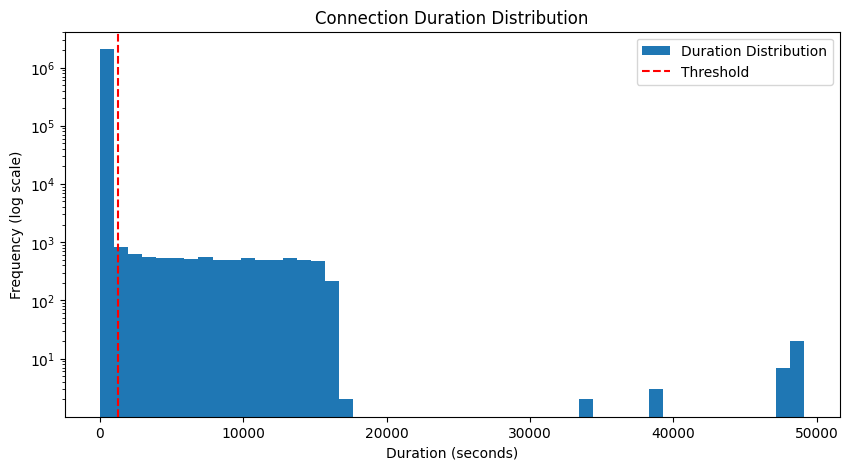


Source IPs with Multiple Protocols (3226 instances):
    source                hour  protocolName
0  0.0.0.0 2010-06-12 03:00:00             3
1  0.0.0.0 2010-06-12 04:00:00             2
2  0.0.0.0 2010-06-12 05:00:00             2
3  0.0.0.0 2010-06-12 11:00:00             2
4  0.0.0.0 2010-06-12 12:00:00             2
Example: 0.0.0.0 in 2010-06-12 03:00:00: Protocols: ['udp_ip' 'ip' 'ipv6icmp']

Destination IPs with Multiple Protocols (8441 instances):
  destination                hour  protocolName
0     0.0.0.0 2010-06-12 03:00:00             3
1     0.0.0.0 2010-06-12 04:00:00             2
2     0.0.0.0 2010-06-12 05:00:00             2
3     0.0.0.0 2010-06-12 11:00:00             2
4     0.0.0.0 2010-06-12 12:00:00             2


In [87]:
#Part c : Suspicious Communication Patterns

df['duration'] = (df['stopDateTime'] - df['startDateTime']).dt.total_seconds()

duration_mean = df['duration'].mean()
duration_std = df['duration'].std()
duration_threshold = duration_mean + 2 * duration_std
print(f"\nDuration Stats: Mean: {duration_mean:.2f}, Std: {duration_std:.2f}, Threshold: {duration_threshold:.2f}")
long_connections = df[df['duration'] > duration_threshold][['source', 'destination', 'duration', 'protocolName', 'startDateTime']]
print("Long-Duration Connections:", len(long_connections))
print(long_connections.head())

plt.figure(figsize=(10, 5))
plt.hist(df['duration'], bins=50, log=True, label='Duration Distribution')
plt.axvline(duration_threshold, color='r', linestyle='--', label='Threshold')
plt.title('Connection Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency (log scale)')
plt.legend()
plt.show()


source_protocols = df.groupby(['source', 'hour'])['protocolName'].nunique()
multi_protocol_ips = source_protocols[source_protocols > 1].reset_index()
print(f"\nSource IPs with Multiple Protocols ({len(multi_protocol_ips)} instances):")
print(multi_protocol_ips.head())

if not multi_protocol_ips.empty:
    top_ip = multi_protocol_ips['source'].iloc[0]
    top_hour = multi_protocol_ips['hour'].iloc[0]
    protocols_used = df[(df['source'] == top_ip) & (df['hour'] == top_hour)]['protocolName'].unique()
    print(f"Example: {top_ip} in {top_hour}: Protocols: {protocols_used}")

dest_protocols = df.groupby(['destination', 'hour'])['protocolName'].nunique()
multi_protocol_dests = dest_protocols[dest_protocols > 1].reset_index()
print(f"\nDestination IPs with Multiple Protocols ({len(multi_protocol_dests)} instances):")
print(multi_protocol_dests.head())

In [88]:


df['duration'] = (df['stopDateTime'] - df['startDateTime']).dt.total_seconds()

# MAD calculation
def calculate_mad(data):
    median = np.median(data)
    deviations = np.abs(data - median)
    mad = np.median(deviations)
    return median, mad

# 1. Stealthy Port Scans
df['duration'] = (df['stopDateTime'] - df['startDateTime']).dt.total_seconds()

# Check for port field
port_field = 'destinationPort' if 'destinationPort' in df.columns else 'appName' if 'appName' in df.columns else None
if not port_field:
    print("Warning: No explicit port field found. Using 'destination' as a proxy.")
    port_field = 'destination'
print(f"Using '{port_field}' as port indicator.")

# Aggregate per source-destination pair
pair_data = df.groupby(['source', 'destination']).agg({
    'duration': 'sum',              # Total duration
})

print(pair_data)

# MAD calculation
def calculate_mad(data):
    median = np.median(data)
    deviations = np.abs(data - median)
    mad = np.median(deviations)
    return median, mad

duration_median, duration_mad = calculate_mad(pair_data['duration'])
duration_threshold = duration_median + 5 * duration_mad  # Long duration

duration_mean = pair_data['duration'].mean()
duration_std = pair_data['duration'].std()
duration_threshold = duration_mean + 2*duration_std
# Detect stealthy scans
stealth_scans = pair_data[(pair_data['duration'] > duration_threshold)]

print(f"\nStealthy Port Scan Candidates ({len(stealth_scans)}):")
if not stealth_scans.empty:
    print(stealth_scans[['duration']])
else:
    print("None detected.")

# 2. Slow DDoS Attacks
# Sustained traffic to a destination over days
dest_data = df.groupby('destination').agg({
    'totalSourceBytes': 'sum',      # Total traffic
    'source': 'nunique',            # Unique sources
    'duration': 'sum',             # Total duration
    'hour': 'nunique'              # Hours active
}).rename(columns={'source': 'unique_sources', 'hour': 'hours_active'})

# Define moderate traffic range
traffic_mean = dest_data['totalSourceBytes'].mean()
traffic_std = dest_data['totalSourceBytes'].std()
traffic_upper = traffic_mean + traffic_std  # Moderate, not extreme
traffic_lower=traffic_mean-traffic_std

# High source count
sources_mean = dest_data['unique_sources'].mean()
sources_std = dest_data['unique_sources'].std()
sources_threshold = traffic_mean + 2*traffic_std  # Moderate, not extreme

# Long duration
duration_mean = dest_data['duration'].mean()
duration_std = dest_data['duration'].std()
duration_threshold=duration_mean+2*duration_std  # Sustained activity

# Detect slow DDoS
slow_ddos = dest_data[(dest_data['totalSourceBytes'].between(traffic_lower, traffic_upper)) &
                      (dest_data['duration'] > duration_threshold)]

if not slow_ddos.empty:
    print(slow_ddos[['totalSourceBytes', 'unique_sources', 'duration', 'hours_active']])
else:
    print("None detected.")

# 3. IP Hopping Behavior
# Cluster sources by shared destinations and timing
source_dest_pairs = df.groupby('source')['destination'].apply(set)

# Calculate shared destinations between all pairs of source IPs
shared_dests = {}
for ip1 in source_dest_pairs.index:
    for ip2 in source_dest_pairs.index:
        if ip1 < ip2:  # Avoid duplicates and self-comparison
            overlap = len(source_dest_pairs[ip1] & source_dest_pairs[ip2])
            if overlap > 0:  # Only store non-zero overlaps
                shared_dests[(ip1, ip2)] = overlap

# Convert to series for thresholding
overlap_counts = pd.Series(shared_dests.values())
overlap_mean = overlap_counts.mean()
overlap_std = overlap_counts.std()
overlap_threshold = overlap_mean + 2 * overlap_std  # Mean + 2*std (95% threshold)

print(f"\nShared Destinations Stats:")
print(f"Mean: {overlap_mean:.2f}")
print(f"Std: {overlap_std:.2f}")
print(f"Threshold: {overlap_threshold:.2f} shared destinations")

# Identify potential hopping pairs
hopping_pairs = [(pair, count) for pair, count in shared_dests.items() if count > overlap_threshold]

# Group into clusters
hopping_groups = {}
for (ip1, ip2), _ in hopping_pairs:
    group_id = min([k for k, v in hopping_groups.items() if ip1 in v or ip2 in v], default=len(hopping_groups))
    if group_id in hopping_groups:
        hopping_groups[group_id].update([ip1, ip2])
    else:
        hopping_groups[group_id] = {ip1, ip2}

# Filter groups with >1 IP and validate with temporal overlap
source_hours = df.groupby('source')['hour'].apply(set)
hopping_candidates = {}
for group_id, ips in hopping_groups.items():
    if len(ips) > 1:
        ips_list = list(ips)
        # Check if any pair in the group has temporal overlap
        has_overlap = False
        for i in range(len(ips_list)):
            for j in range(i + 1, len(ips_list)):
                if source_hours[ips_list[i]] & source_hours[ips_list[j]]:
                    has_overlap = True
                    break
            if has_overlap:
                break
        if has_overlap:
            hopping_candidates[group_id] = ips

print(f"\nIP Hopping Candidates ({len(hopping_candidates)} groups):")
for group_id, ips in hopping_candidates.items():
    print(f"Group {group_id}: {list(ips)}")

Using 'destinationPort' as port indicator.
                                 duration
source          destination              
0.0.0.0         0.0.0.0           87060.0
                255.255.255.255       0.0
10.64.250.65    192.168.2.107       180.0
108.104.140.217 192.168.2.107       120.0
108.13.77.61    192.168.2.107         0.0
...                                   ...
99.23.136.226   192.168.2.107         0.0
99.245.96.20    192.168.2.107         0.0
99.28.223.244   192.168.2.107         0.0
99.51.237.200   192.168.2.107       300.0
99.57.185.134   192.168.2.107        60.0

[59981 rows x 1 columns]

Stealthy Port Scan Candidates (51):
                                duration
source        destination               
192.168.1.101 192.168.1.105    2083740.0
              192.168.1.255    2416500.0
              192.168.5.122     210540.0
              195.189.143.147  1682640.0
              255.255.255.255  2392740.0
              67.111.12.102     126780.0
192.168.1.102 91.190

In [89]:
import math
import base64

def calculate_entropy(data):
    if not data or pd.isna(data):
        return 0
    try:
        raw_data = base64.b64decode(data)
    except:
        return 0
    length = len(raw_data)
    if length == 0:
        return 0
    freq = {}
    for byte in raw_data:
        freq[byte] = freq.get(byte, 0) + 1
    probs = [f / length for f in freq.values()]
    entropy = -sum(p * math.log2(p) for p in probs)
    return entropy

# Calculate entropy for source and destination payloads
df['src_entropy'] = df['sourcePayloadAsBase64'].apply(calculate_entropy)
df['dst_entropy'] = df['destinationPayloadAsBase64'].apply(calculate_entropy)

# Display flows with unusually high entropy (e.g., >7.5)
high_entropy_flows = df[(df['src_entropy'] > 7.5) | (df['dst_entropy'] > 7.5)]

print(f"High entropy flows detected: {len(high_entropy_flows)}")
high_entropy_flows[['source', 'destination', 'src_entropy', 'dst_entropy', 'protocolName', 'sourcePort', 'destinationPort']]


High entropy flows detected: 1013


,source,destination,src_entropy,dst_entropy,protocolName,sourcePort,destinationPort
115400,192.168.2.107,204.152.184.113,5.055581,7.545730,tcp_ip,1755,80
115650,192.168.4.121,174.35.52.82,0.000000,7.786966,tcp_ip,56106,80
129187,192.168.2.109,72.32.186.241,4.737747,7.535913,tcp_ip,2449,80
131102,192.168.1.103,74.208.9.192,5.374067,7.500006,tcp_ip,2524,80
138192,192.168.2.112,131.202.243.84,7.542319,5.009110,tcp_ip,1888,5555
...,...,...,...,...,...,...,...
474782,192.168.2.112,63.146.109.204,4.704575,7.516884,tcp_ip,3700,80
490754,192.168.1.103,72.21.211.164,5.364527,7.519417,tcp_ip,1484,80
504029,192.168.1.104,64.214.232.121,4.693434,7.556928,tcp_ip,26349,80
506298,192.168.2.108,112.78.198.40,0.000000,7.509532,tcp_ip,1758,80


In [90]:
# Define typical encrypted ports
encrypted_ports = {443, 993, 995, 465, 8443,80,8080}

# Filter flows with high entropy payloads
df['is_high_entropy'] = (df['src_entropy'] > 7.5) | (df['dst_entropy'] > 7.5)

# Flag those that do NOT use standard encrypted ports
df['abnormal_encrypted_traffic'] = df['is_high_entropy'] & \
                                   (~df['destinationPort'].isin(encrypted_ports)) & \
                                   (~df['sourcePort'].isin(encrypted_ports))

# Display suspicious encrypted traffic
abnormal_encrypted = df[df['abnormal_encrypted_traffic']]
print(f"Suspicious encrypted flows found: {len(abnormal_encrypted)}")
abnormal_encrypted[['source', 'destination', 'sourcePort', 'destinationPort', 'protocolName', 'src_entropy', 'dst_entropy']]


Suspicious encrypted flows found: 384


,source,destination,sourcePort,destinationPort,protocolName,src_entropy,dst_entropy
138192,192.168.2.112,131.202.243.84,1888,5555,tcp_ip,7.542319,5.009110
157145,192.168.2.107,201.93.249.138,58040,65145,udp_ip,5.612374,7.562251
157147,192.168.2.107,95.79.144.25,58040,19785,udp_ip,5.782111,7.548728
157151,192.168.2.107,114.45.54.127,58040,14040,udp_ip,5.724001,7.577571
157154,192.168.2.107,86.0.197.46,58040,11207,udp_ip,5.648624,7.513712
...,...,...,...,...,...,...,...
383622,192.168.3.116,77.251.15.117,34976,4983,udp_ip,4.910992,7.627821
383652,192.168.3.116,24.91.156.189,34976,18243,udp_ip,4.910992,7.675197
478441,131.202.243.84,192.168.2.112,5555,1643,tcp_ip,7.736471,7.675853
479968,192.168.2.112,131.202.243.84,1643,5555,tcp_ip,7.514997,5.009110


In [91]:
import numpy as np

# Step 1: Aggregate flows by (source, destination)
flow_stats = df.groupby(['source', 'destination']).agg({
    'totalSourceBytes': 'sum',
    'totalDestinationBytes': 'sum',
    'totalSourcePackets': 'sum',
    'totalDestinationPackets': 'sum',
    'startDateTime': 'count'
}).reset_index()

# Rename for clarity
flow_stats.rename(columns={'startDateTime': 'flow_count'}, inplace=True)

# Step 2: Heuristic filters for C&C patterns
# - Low total bytes but high number of flows
# - Or very few packets per flow
flow_stats['total_bytes'] = flow_stats['totalSourceBytes'] + flow_stats['totalDestinationBytes']
flow_stats['total_packets'] = flow_stats['totalSourcePackets'] + flow_stats['totalDestinationPackets']
flow_stats['bytes_per_flow'] = flow_stats['total_bytes'] / flow_stats['flow_count']
flow_stats['packets_per_flow'] = flow_stats['total_packets'] / flow_stats['flow_count']

# Step 3: Apply C&C-like conditions
cc_candidates = flow_stats[
    (flow_stats['flow_count'] >= 5) &
    (flow_stats['bytes_per_flow'] < 500) &  # small payload
    (flow_stats['packets_per_flow'] < 10)   # few packets per flow
]

print(f"Potential C&C communication pairs found: {len(cc_candidates)}")
cc_candidates[['source', 'destination', 'flow_count', 'bytes_per_flow', 'packets_per_flow']]


Potential C&C communication pairs found: 3985


,source,destination,flow_count,bytes_per_flow,packets_per_flow
2,10.64.250.65,192.168.2.107,10,259.000000,3.500000
9,109.105.165.88,192.168.2.107,5,251.000000,2.200000
27,109.197.48.50,192.168.2.107,15,356.666667,4.333333
46,109.92.108.167,192.168.2.107,13,324.461538,4.384615
47,109.93.202.76,192.168.2.107,17,304.705882,4.117647
...,...,...,...,...,...
59945,96.56.113.234,192.168.2.107,11,376.727273,5.090909
59947,97.112.134.194,192.168.2.107,8,338.875000,3.125000
59952,97.86.15.78,192.168.2.107,9,312.444444,4.222222
59967,98.248.105.184,192.168.2.107,5,458.800000,6.200000
